# Maximize Fairness Under Accuracy Constraints - Logistic Regression

Bank dataset - https://archive.ics.uci.edu/ml/machine-learning-databases/00222/ and download bank.zip and place bank-full.csv in the data folder

COMAPS - https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv download csv and place in data folder

## Bank Dataset - As used in the Paper Evaluation Section

### 1) Preprocess Bank marketing Data

In [14]:
#Load data 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import log_loss
from scipy import optimize
import copy
import itertools
import math
from sklearn.svm import SVC
from sklearn.utils import shuffle

fp = "../data/bank-full.csv"
bank_df = pd.read_csv(fp, delimiter=";")

As outlined in the paper, the bank dataset was used to evaluate the model. In the paper, the authors use age as the sensitive attribute, where ages between 25 and 60 are the protected group and the remaining ages are the non protected group. The logistic model predicts whether or not a person subscribed to a term deposit. Features used for classification are marital status, job, education level, method of contact, whether or not the person defaulted on a previous loan, and whether they had a previous loan. 


In [3]:

def process_data(bank_df): 
  
  y_actual = bank_df["y"].apply(lambda x: 1 if x == "yes" else -1)
  age = bank_df["age"].apply(lambda x: 1 if 25<= x <= 60 else 0)
  bank_df = bank_df.drop(columns = ["age", "y", "day", "month"])

  #Have more than two categories - one hot encode
  columns = ['job', 'marital', 'education','contact','poutcome']
  for c in columns: 
    dummies = pd.get_dummies(bank_df[c])
    bank_df = pd.merge(bank_df, dummies, left_index = True, right_index = True)
    bank_df = bank_df.drop(columns = [c])

  #Binary variables, apply 1/0 for yes/no
  binary_vars = ['default', 'housing', 'loan']
  for b in binary_vars: 
    bank_df[b] = bank_df[b].apply(lambda x: 1 if x =="yes" else 0 )

  bank_df, y_actual, age = shuffle(bank_df, y_actual, age, random_state=0)

  return bank_df.to_numpy(), y_actual.to_numpy(), age.to_numpy()

def accuracy(w, x, y):
  shape = x.shape[1]
  pred = np.dot(x, w.reshape(shape,1))
  pred_prob = 1/(1+ 2.718**(-pred))
  
  pred_prob[pred_prob>=0.5] = 1
  pred_prob[pred_prob<0.5] = -1

  matches = np.where(pred_prob== y.reshape(pred_prob.shape))

  return (matches[0].shape[0]/pred_prob.shape[0]), pred_prob

#Determine p% rule ratio - number of protected (age btw 25 and 60) in the positive class: 
#not protected (less than 25 or older than 60) in positive class
def p_rule(age_var, predicted_y):
  
  not_protected = np.where(age_var != 1)[0]
  protected = np.where(age_var == 1)[0] 

  protected_preds = np.where(predicted_y[protected] == 1)
  nonpro_preds = np.where(predicted_y[not_protected] == 1)
  protected_perc = (protected_preds[0].shape[0]/protected.shape[0]) 
  nonpro_perc = (nonpro_preds[0].shape[0]/not_protected.shape[0])

  perc_ratio = protected_perc/nonpro_perc

  return perc_ratio, protected_perc, nonpro_perc

In [4]:
X, y, age = process_data(bank_df)

#X,y, and age shuffled already, split into train and test tests
train_index = int(len(X)*.80)
x_train, y_train, age_train = X[:train_index], y[:train_index], age[:train_index]
x_test, y_test, age_test = X[train_index:], y[train_index:], age[train_index:]

### Train Logistic Regression model without any constraints 

In [6]:
#Get optimal coefficients by just training normal LR model 
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print(f"Logistic Regression Accuracy: {clf.score(x_train, y_train)}")
print(f"P-rule value: {p_rule(age_train, clf.predict(x_train))}")

coeff = clf.coef_
intercept = clf.intercept_
optimal_loss = log_loss(y_train, clf.predict_proba(x_train))


/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy: 0.8997179827471798
P-rule value: (0.27308801279219336, 0.05042673224359902, 0.18465377417342482)


In [7]:
print(f"Logistic Regression Accuracy: {clf.score(x_test, y_test)}")
print(f"P-rule value: {p_rule(age_test, clf.predict(x_test))}")

Logistic Regression Accuracy: 0.9016919163994249
P-rule value: (0.3003949522521662, 0.05260723783096312, 0.1751269035532995)


### Add lift factor to dataset, functions for optimization problem as defined in paper

In [112]:
#Reshape arrays to calcualte dist from decision boundary 
ind = x_train.shape[0]
ind_test = x_test.shape[0] 

lift = np.ones(ind).reshape(ind, 1)
lift_test = np.ones(ind_test).reshape(ind_test, 1)
x_test =  np.concatenate((x_test, lift_test), axis = 1)
x_train = np.concatenate((x_train, lift), axis = 1)

optimal_weights_bank = np.concatenate((coeff, intercept.reshape(1,1)), axis = 1)

In [101]:
#Create Constraints for optimization problem 
def logisitc_loss(weights, X, y):
  
  shape = x_train.shape[1]
  dp = np.dot(X, weights.reshape(shape,1))
  dp = dp.astype(np.float64)
  pred_prob = 1/(1+ 2.718**(-dp))

  pred_classes = np.concatenate((1-pred_prob, pred_prob), axis = 1)
  loss = log_loss(y, pred_classes)

  return loss 

def constraint1(weights, x, y, gamma):
  
  upd_loss = logisitc_loss(weights, x, y)

  return (1+gamma)*optimal_loss - upd_loss #Accuracy constraint function from paper 

#Optmization function to minimize - from paper 
def opt_function(w, x, protected_var):
  
  dist_bound = np.dot(w, x_train.T)
  protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
  
  return float(abs(sum(protected_cov))) / float(x_train.shape[0])

In [118]:
#https://towardsdatascience.com/optimization-with-scipy-and-application-ideas-to-machine-learning-81d39c7938b8
#Run a single optimization with a defined Gamma 
def run_optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    constraints = []
    cons = {'type':'ineq', 'fun': constraint1, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(opt_function,
                               x0=optimal_weights,
                               args= (x_train,protected_attr),
                               method='SLSQP',
                               constraints=cons,
                               options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule(protected_attr, pred_y)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule(protected_attr_test, y_pred_test)
    
    print(f"Accuracy for gamma {gamma}: {accuracy_train}")
    print(f"P Rule Value: {p_rule_val}")
    print (f"Perc of protected vs non protected in positive class: {prot_perc}: {nonp_perc}")
    
    return accuracy_train,pred_y, p_rule_val, prot_perc, nonp_perc, accuracy_test, p_rule_val_test, prot_perc_test, nonp_perc_test 


In [119]:
#Run multiple optimizations for multiple gammas values
def run_mult_optmizations(x_train, y_train, x_test,y_test, protected_attr, protected_attr_test, optimal_weights, gamma_list):
    
    accuracy_list, p_val_list, prot_perc_list, nonpro_perc_list = [],[],[],[]
    accuracy_list_test, p_val_list_test, prot_perc_list_test, nonpro_perc_list_test = [],[],[],[]
    for g in gamma_list: 
        (accuracy_train, pred_y, p_rule_val, prot_perc, nonp_perc,
        accuracy_test, p_rule_val_test, prot_perc_test, nonp_perc_test) = run_optimization(x_train, 
                                                                                          y_train,
                                                                                          x_test,
                                                                                          y_test,
                                                                                          protected_attr, 
                                                                                          protected_attr_test,
                                                                                          g, 
                                                                                          optimal_weights)
        accuracy_list.append(accuracy_train)
        p_val_list.append(p_rule_val)
        prot_perc_list.append(prot_perc)
        nonpro_perc_list.append(nonp_perc)
        
        accuracy_list_test.append(accuracy_test)
        p_val_list_test.append(p_rule_val_test)
        prot_perc_list_test.append(prot_perc_test)
        nonpro_perc_list_test.append(nonp_perc_test)
        
    return accuracy_list, p_val_list, prot_perc_list, nonpro_perc_list,accuracy_list_test, p_val_list_test, prot_perc_list_test, nonpro_perc_list_test
        
    

### Run optimization for different gamma values 

In [120]:
(acc, p_val_list, protected, nonpro, 
 acc_test, p_val_list_test, protected_test, nonpro_test) = run_mult_optmizations(x_train, 
                                                                                y_train, 
                                                                                x_test, 
                                                                                y_test, 
                                                                                age_train,
                                                                                age_test, 
                                                                                optimal_weights_bank, 
                                                                                [0.1,0.15,0.2])

/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys


Accuracy for gamma 0.1: 0.8956536164565362
P Rule Value: 0.7409437561184018
Perc of protected vs non protected in positive class: 0.0397511934037321: 0.053649407361197755


/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys


Accuracy for gamma 0.15: 0.8932205264322053
P Rule Value: 0.8106070823901895
Perc of protected vs non protected in positive class: 0.035903370461449445: 0.044291952588895823


/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflo

Accuracy for gamma 0.2: 0.8903174076531741
P Rule Value: 0.8579632576305513
Perc of protected vs non protected in positive class: 0.024620280630695792: 0.028696194635059263


Train Accuracy and P% Rule


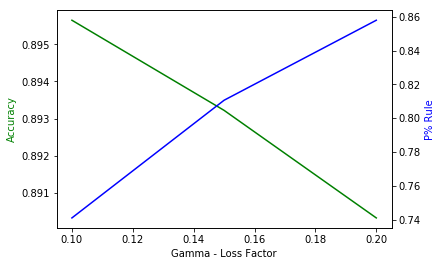

In [128]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot([0.1,0.15,0.2], acc , 'g-')
ax2.plot([0.1,0.15,0.2], p_val_list, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Test Accuracy and P% Rule


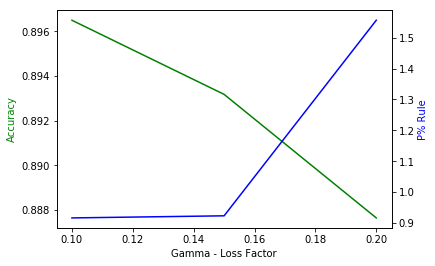

In [129]:
fig, ax1 = plt.subplots()
print("Test Accuracy and P% Rule")
ax2 = ax1.twinx()
ax1.plot([0.1,0.15,0.2], acc_test , 'g-')
ax2.plot([0.1,0.15,0.2], p_val_list_test, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

# COMPAS DATASET 

The COMPAS dataset was not used for evaluation in the paper, but implemented below to predict the two_year_recid binary label. 

In [8]:
fp = '../data/compas-scores-two-years.csv'
compas_df = pd.read_csv(fp)


In [9]:
def process_compas_dataset(compas_df): 
    #Drop Missing values and subset on columns needed
    compas_df.dropna()
    compas_subset = compas_df[["sex","age","age_cat","race","priors_count","c_charge_degree","c_jail_in", "c_jail_out",'two_year_recid']]
    compas_subset["two_year_recid"] = compas_subset["two_year_recid"].apply(lambda x: -1 if x==0 else 1)
    
    #Only select Caucasian/African American, encode to 0/1
    compas_subset = compas_subset[(compas_subset["race"]=='Caucasian') |(compas_subset["race"]=='African-American') ]
    compas_subset["race_cat"] = compas_subset["race"].apply(lambda x: 1 if x == "Caucasian" else 0)
    compas_subset = compas_subset.drop(columns = "race")
    
    #Encode gender to 0/1
    compas_subset["gender_cat"] = compas_subset["sex"].apply(lambda x: 1 if x == "Female" else 0)
    compas_subset = compas_subset.drop(columns = "sex")
    
    #Encode charge degree to 0/1
    compas_subset["charge_cat"] = compas_subset["c_charge_degree"].apply(lambda x: 1 if x == "F" else 0)
    compas_subset = compas_subset.drop(columns = "c_charge_degree")
    
    #Calculate length of stay from jail out - jail in 
    compas_subset["length_stay"] = pd.to_datetime(compas_subset["c_jail_out"]) - pd.to_datetime(compas_subset['c_jail_in'])
    compas_subset["length_stay"] = compas_subset["length_stay"].apply(lambda x: x.days)
    compas_subset = compas_subset.drop(columns = ["c_jail_in","c_jail_out"])
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 0 if x <= 7 else x)
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 1 if 7< x <= 90 else x)
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 2 if x > 90 else x)
    
    #Categorize priors count into 3 categories 
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 0 if x==0 else x)
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 1 if (1<=x<=3) else x)
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 2 if x>3 else x)
    
    #One hot encode age_cat 
    dummies = pd.get_dummies(compas_subset["age_cat"])
    compas_subset = pd.merge(compas_subset, dummies, left_index = True, right_index = True)
    compas_subset = compas_subset.drop(columns = ["age_cat","age"])
    
    compas_subset = compas_subset.dropna()
    y_label = compas_subset["two_year_recid"]
    protected_attribute = compas_subset["race_cat"]
    df = compas_subset.drop(columns=["two_year_recid","race_cat"])

    y_label, protected_attr, df = shuffle(y_label, protected_attribute, df, random_state = 0)

    return y_label.to_numpy(), protected_attr.to_numpy(), df.to_numpy()

In [10]:
y_label, protected_attr, X =  process_compas_dataset(compas_df)

train_index = int(len(X)*.80)
x_train, y_train, race_train = X[:train_index], y_label[:train_index], protected_attr[:train_index]
x_test, y_test, race_test = X[train_index:], y_label[train_index:],protected_attr[train_index:]

/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print(f"Logistic Regression Accuracy: {clf.score(x_train, y_train)}")
print(f"P-rule: {p_rule(race_train, clf.predict(x_train))}")
coeff = clf.coef_
intercept = clf.intercept_
optimal_loss = log_loss(y_train, clf.predict_proba(x_train))

Logistic Regression Accuracy: 0.6642011834319527
P-rule: (0.5974526902979804, 0.32718651211801897, 0.547635850388144)


/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
print(f"Logistic Regression Accuracy: {clf.score(x_test, y_test)}")
p_rule(race_test, clf.predict(x_test))


Logistic Regression Accuracy: 0.661876584953508


(0.6573326771653544, 0.35625, 0.5419630156472262)

In [135]:
#Reshape arrays to calcualte dist from decision boundary 
ind = x_train.shape[0]
ind_test = x_test.shape[0] 

lift = np.ones(ind).reshape(ind, 1)
lift_test = np.ones(ind_test).reshape(ind_test, 1)
x_test =  np.concatenate((x_test, lift_test), axis = 1)
x_train = np.concatenate((x_train, lift), axis = 1)

optimal_weights_compas = np.concatenate((coeff, intercept.reshape(1,1)), axis = 1)

In [137]:
(compas_acc, compas_p_val_list, compas_protected, compas_nonpro, 
 compas_acc_test, compas_p_val_list_test, compas_protected_test, compas_nonpro_test) = run_mult_optmizations(x_train, 
                                                                                y_train, 
                                                                                x_test, 
                                                                                y_test, 
                                                                                race_train,
                                                                                race_test, 
                                                                                optimal_weights_compas, 
                                                                                [0.05,0.1,0.11])

Accuracy for gamma 0.05: 0.6299661876584953
P Rule Value: 0.6802906157982332
Perc of protected vs non protected in positive class: 0.3082191780821918: 0.45306986591390264
Accuracy for gamma 0.1: 0.5617075232459848
P Rule Value: 0.9035258405977584
Perc of protected vs non protected in positive class: 0.2244467860906217: 0.24841213832039521
Accuracy for gamma 0.11: 0.5420540997464074
P Rule Value: 1.0219080928786552
Perc of protected vs non protected in positive class: 0.10168598524762908: 0.0995059985885674


Train Accuracy and P% Rule


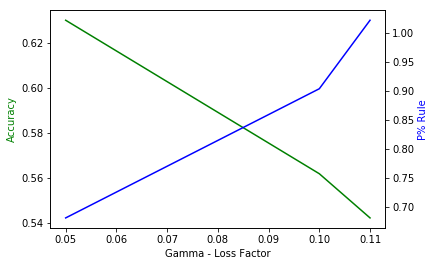

In [138]:
import matplotlib.pyplot as plt
print("Train Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( [0.05,0.1,0.11], compas_acc , 'g-')
ax2.plot( [0.05,0.1,0.11], compas_p_val_list, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

Test Accuracy and P% Rule


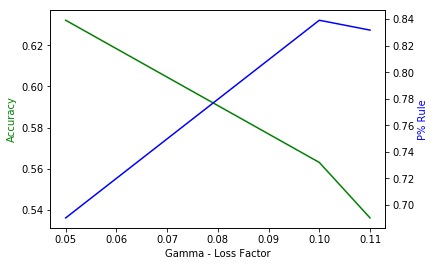

In [139]:
print("Test Accuracy and P% Rule")
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( [0.05,0.1,0.11], compas_acc_test , 'g-')
ax2.plot( [0.05,0.1,0.11], compas_p_val_list_test, 'b-')

ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('P% Rule', color='b')

plt.show()

# Fairness Aware Feature Selection 

In this section, we implement the routines described in "Information Theoretic Measures for Fairness-aware Feature Selection." On the training data, we calculate Shapley coefficients for each of our features capturing effects on both accuracy and discrimation on our protected group (i.e. race).

In [15]:
#Still using compas dataset for evaluation 
y_label, protected_attr, X =  process_compas_dataset(compas_df)

train_index = int(len(X)*6./7.)
x_train, y_train, race_train = X[:train_index], y_label[:train_index], protected_attr[:train_index]
x_test, y_test, race_test = X[train_index:], y_label[train_index:],protected_attr[train_index:]

/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
"""This cell contains utility functions called in the proceeding cells."""

def get_uniq_vals_in_arr(arr):
    """Returns unique values in array.
    
    :param arr (np.array) n * m matrix
    :return (list) uniq_vals[i] contains unique values of ith column in arr
    """
    uniq_vals = []
    for id_col in range(arr.shape[1]):
        uniq_vals.append(np.unique(arr[:, id_col]).tolist())
    return uniq_vals


def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [17]:
"""This cell contains code for all the routines needed to calculate the Shapley coefficients."""

def get_info_coef(left, right):
    # Both arrays NEED same number of rows
    assert left.shape[0] == right.shape[0]
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
        
    concat_mat = np.concatenate((left, right), axis=1)
    concat_uniq_vals = get_uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((right == vec[num_left_cols:]).all(axis=1))[0]) / num_rows
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r1) / p_r1
        p_sum += np.abs(p_iter)
    return p_sum


def get_conditional_info_coef(left, right, conditional): 
    assert (left.shape[0] == right.shape[0]) and (left.shape[0] == conditional.shape[0])
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
    num_right_cols = right.shape[1]

    right_concat_mat = np.concatenate((right, conditional), axis=1)    
    concat_mat = np.concatenate((left, right_concat_mat), axis=1)
    concat_uniq_vals = get_uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((concat_mat[:, num_left_cols: -num_right_cols] == vec[num_left_cols: -num_right_cols]).all(axis=1))[0]) / num_rows
        
        try:
            p_r1_given_r3 = len(np.where((concat_mat[:, :num_left_cols] == vec[:num_left_cols]).all(axis=1) & (concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0]) / len(np.where((concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0])
        except ZeroDivisionError:
            p_r1_given_r3 = 0
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0 or p_r1_given_r3 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r2) / p_r1_given_r3
        p_sum += np.abs(p_iter)
    return p_sum


def get_acc_coef(y, x_s, x_s_c, protected_attr):
    conditional = np.concatenate((x_s_c, protected_attr), axis=1)
    return get_conditional_info_coef(y, x_s, conditional)


def get_disc_coef(y, x_s, protected_attr):
    x_s_a = np.concatenate((x_s, protected_attr), axis=1)
    return get_info_coef(y, x_s_a) * get_info_coef(x_s, protected_attr) * get_conditional_info_coef(x_s, protected_attr, y)


def get_shapley_acc_i(y, x, protected_attr, i):
    """Returns Shapley coeffecient of ith feature in x."""
    
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        idx_xsc_incl = list(set(list(range(num_features))).difference(set(idx_xs_incl)))
        acc_incl = get_acc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], x[:, idx_xsc_incl], protected_attr.reshape(-1, 1))
        
        # Calculate v(T)
        idx_xsc_excl = list(range(num_features))
        idx_xsc_excl.pop(i)
        idx_xsc_excl = list(set(idx_xsc_excl).difference(set(set_idx)))
        acc_excl = get_acc_coef(y.reshape(-1, 1), x[:, set_idx], x[:, idx_xsc_excl], protected_attr.reshape(-1, 1))
        
        marginal = acc_incl - acc_excl
        shapley = shapley + coef * marginal
    return shapley


def get_shapley_disc_i(y, x, protected_attr, i):
    """Returns Shapley coeffecient of ith feature in x."""
    
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v_D(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        disc_incl = get_disc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], protected_attr.reshape(-1, 1))
        
        # Calculate v_D(T)
        disc_excl = get_disc_coef(y.reshape(-1, 1), x[:, set_idx], protected_attr.reshape(-1, 1))
        
        marginal = disc_incl - disc_excl
        shapley = shapley + coef * marginal
    return shapley

In [18]:
# Calculate Shapley disc, acc coefs for each feature over training data
shap_acc = []
shap_disc = []
for i in range(5):
    acc_i = get_shapley_acc_i(y_train, x_train, race_train, i)
    disc_i = get_shapley_disc_i(y_train, x_train, race_train, i)
    
    shap_acc.append(acc_i)
    shap_disc.append(disc_i)

# Build Shapley output
feature_names = ["Prior Count", "Gender", "Charge Degree", "Length of Stay", "Age (Categorical)"]
shapley_df = pd.DataFrame(list(zip(feature_names, shap_acc, shap_disc)),
                          columns=["Feature", "Shapley (Accuracy)", "Shapley (Discrimination)"])
shapley_df = shapley_df.sort_values(by=["Shapley (Discrimination)"], ascending=[False]).reset_index(0, True)
shapley_df.to_csv("../output/compas-data-shapley-table.csv")

In [19]:
pd.set_option('display.float_format', lambda x: '%.2E' % x)
shapley_df

,Feature,Shapley (Accuracy),Shapley (Discrimination)
0,Prior Count,1.07E+00,5.91E+04
1,Length of Stay,8.93E-01,5.81E+04
2,Charge Degree,8.53E-01,4.76E+04
3,Gender,7.53E-01,4.73E+04
4,Age (Categorical),1.57E-01,1.04E+04


We see that 'Prior Count' has the sharpest affect on both discrimination and accuracy, so eliminating it can prove problematic for a classifier. However, a feature such as 'Age (Categorical)' is relatively discriminatory but eliminating it would not seriously reduce accuracy from our results.


### Classification
Now, we build an SVM model that predicts whether a user will or will not recidivate given the aforementioned features. We calculate accuracy as well as calibration, the difference between accuracy amongst the groups. Finally, we build submodels which eliminate each feature iteratively and calculate both metrics.

In [20]:
test_acc = []
test_cal = []

# Build model for overall data inclusive of all features
svm = SVC(kernel="linear").fit(x_train, y_train)
idx_race_1, idx_race_0  = np.where(race_test == 1)[0], np.where(race_test == 0)[0]
test_acc.append(svm.score(x_test, y_test))
test_cal.append(svm.score(x_test[idx_race_1], y_test[idx_race_1]) - svm.score(x_test[idx_race_0], y_test[idx_race_0]))

# Eliminate one feature at a time build model
for id_feature in range(x_train.shape[1]):
    idxs = list(range(x_train.shape[1]))
    idxs.pop(id_feature)
    x_train_mod = x_train[:, idxs]
    x_test_mod = x_test[:, idxs]
    
    svm = SVC(kernel="linear").fit(x_train_mod, y_train)
    acc = svm.score(x_test_mod, y_test)
    cal = svm.score(x_test_mod[idx_race_1], y_test[idx_race_1]) - svm.score(x_test_mod[idx_race_0], y_test[idx_race_0])
    
    test_acc.append(acc)
    test_cal.append(cal)
    

index_names = ["None", "Prior Count", "Gender", "Charge Degree", "Length of Stay", "Age (Categorical)"]
test_acc = [x * 100 for x in test_acc]
test_cal = [x * 100 for x in test_cal]
results = pd.DataFrame(list(zip(index_names, test_acc, test_cal)),
                          columns=["Eliminating Feature", "Accuracy (%)", "Calibration (%)"])
results["Delta (%)"] = 2.00 - results["Calibration (%)"]
results.to_csv("../output/compas-data-test-results.csv")

In [21]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
results

,Eliminating Feature,Accuracy (%),Calibration (%),Delta (%)
0,None,63.79,3.60,-1.60
1,Prior Count,56.69,2.52,-0.52
2,Gender,66.98,-1.35,3.35
3,Charge Degree,65.09,-1.05,3.05
4,Length of Stay,62.84,2.78,-0.78
5,Age (Categorical),66.75,-0.95,2.95


When evaluating the results, we must compare against the baseline calibration score of 2%.

Clearly, our results differ somewhat from our pretraining procedures. For example, we show that eliminating 'Prior Count' should result in the strongest drop in discrimation but the results suggest that actually eliminating 'Gender' yields the greatest benefit to discrimation. However, our FFS process showed that dropping 'Charge Degree' is unnecessary and the results prove that as removing it from the training set results in a significantly more discriminatory classifier.